In [11]:
# 📦 Стандартные библиотеки
import os
import time
import json
import random
import glob 
import csv
import shutil
from tqdm import tqdm

from copy import deepcopy
from pathlib import Path

# 📊 Научные библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error
)

# 🔥 PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# 🧠 PyTorch Geometric
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import (
    GCNConv,
    BatchNorm,
    global_mean_pool,
    global_max_pool,
    global_add_pool
)


In [12]:
# ----------------------------
# Device setup
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🛠 Device: {device}")

🛠 Device: cpu


In [13]:
# ----------------------------
# Paths setup (UNIX style)
# ----------------------------

from pathlib import Path

DATA_ROOT = Path("/mnt/d/projects/wind_pressure_prediction_GNN/data/processed/Graphs_train/")
SAVE_ROOT = Path("/mnt/d/projects/wind_pressure_prediction_GNN/final_model/gnn_0.01lr_16bs_128hc_3lyr_relu_bn_maxpool_adam/")
CONFIG_PATH = SAVE_ROOT / "gnn_0.01lr_16bs_128hc_3lyr_relu_bn_maxpool_adam.json"
LOG_CSV_PATH = SAVE_ROOT / "stability_log.csv"

In [14]:
# 🔧 Путь к графам трейна (для Linux / WSL)

def load_train_graphs(DATA_ROOT):
    """
    Загружает графы из указанной директории и возвращает список объектов Data (PyG)
    """
    graphs = []
    for filename in os.listdir(DATA_ROOT):
        if filename.endswith(".pt"):
            path = os.path.join(DATA_ROOT, filename)
            try:
                data = torch.load(path, weights_only=False)  # 👈 обязательно для PyTorch 2.6+
                graphs.append(data)
            except Exception as e:
                print(f"⚠️ Ошибка при загрузке {filename}: {e}")
    print(f"✅ Загружено {len(graphs)} графов из {DATA_ROOT}")
    return graphs

# 📦 Загрузка графов
dataset = load_train_graphs(DATA_ROOT)

✅ Загружено 486 графов из /mnt/d/projects/wind_pressure_prediction_GNN/data/processed/Graphs_train


In [15]:
class GCNRegressor(nn.Module):
    def __init__(
        self,
        in_channels,
        hidden_channels,
        out_channels,
        num_layers=3,
        activation_fn=nn.ReLU(),
        use_batchnorm=True,
        pooling='mean',  # 'mean', 'max', 'add'
        dropout=0.2
    ):
        super(GCNRegressor, self).__init__()

        self.activation_fn = activation_fn
        self.use_batchnorm = use_batchnorm
        self.dropout = dropout

        # 🔹 Слои GCN
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        self.convs.append(GCNConv(in_channels, hidden_channels))
        if use_batchnorm:
            self.bns.append(BatchNorm(hidden_channels))

        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
            if use_batchnorm:
                self.bns.append(BatchNorm(hidden_channels))

        # 🔹 Пулинг
        if pooling == 'mean':
            self.pool = global_mean_pool
        elif pooling == 'max':
            self.pool = global_max_pool
        elif pooling == 'add':
            self.pool = global_add_pool
        else:
            raise ValueError(f"Unsupported pooling method: {pooling}")

        # 🔹 Финальный регрессор
        self.lin1 = nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if self.use_batchnorm:
                x = self.bns[i](x)
            x = self.activation_fn(x)

        x = self.lin1(x)
        x = self.activation_fn(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin2(x)
        return x

In [16]:
def evaluate_gnn_model(model, dataloader, device='cpu', save_dir=None, save_prefix="_eval"):
    model.eval()
    model.to(device)

    y_true_all = []
    y_pred_all = []

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)

            outputs = model(batch.x, batch.edge_index, batch.batch)
            y_pred_all.extend(outputs.squeeze().cpu().numpy())
            y_true_all.extend(batch.y.squeeze().cpu().numpy())

    # 🧮 Метрики
    y_true = np.array(y_true_all)
    y_pred = np.array(y_pred_all)

    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    return r2, mae, mse


In [17]:
def train_gnn_simple(
    dataset,
    model_class,
    model_params,
    loss_fn,
    optimizer_class,
    optimizer_params,
    num_epochs,
    device,
    batch_size,
    run_id,
    val_split=0.2,
    val_every=10,
    early_stopping_rounds=15,
    metric_for_early_stopping="r2",
    maximize=True,
):
    # 🔀 Разделение на train/val
    num_total = len(dataset)
    num_val = int(num_total * val_split)
    indices = list(range(num_total))
    random.shuffle(indices)

    val_idx = indices[:num_val]
    train_idx = indices[num_val:]

    train_subset = [dataset[i] for i in train_idx]
    val_subset = [dataset[i] for i in val_idx]

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # 🧠 Инициализация модели и оптимизатора
    model = model_class(**model_params).to(device)
    optimizer = optimizer_class(model.parameters(), **optimizer_params)

    best_metric = -np.inf if maximize else np.inf
    no_improve_epochs = 0
    history = []
    best_model_state_dict = None

    for epoch in tqdm(range(1, num_epochs + 1), desc="📈 Training"):
        model.train()
        total_loss = 0.0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out.squeeze(), batch.y.squeeze())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)

        # 🔍 Валидация
        if epoch % val_every == 0 or epoch == 1 or epoch == num_epochs:
            model.eval()
            y_true_all = []
            y_pred_all = []

            with torch.no_grad():
                for batch in val_loader:
                    batch = batch.to(device)
                    out = model(batch.x, batch.edge_index, batch.batch).squeeze()
                    y_true_all.append(batch.y.squeeze().cpu())
                    y_pred_all.append(out.cpu())

            y_true_all = torch.cat(y_true_all).numpy()
            y_pred_all = torch.cat(y_pred_all).numpy()

            r2 = r2_score(y_true_all, y_pred_all)
            mae = mean_absolute_error(y_true_all, y_pred_all)
            mse = mean_squared_error(y_true_all, y_pred_all)

            print(f"📉 Epoch {epoch:02d} | Train Loss: {avg_loss:.6f} | "
                  f"Val R²: {r2:.4f} | MAE: {mae:.4f} | MSE: {mse:.6f}")

            current_metric = {"r2": r2, "mae": mae, "mse": mse}[metric_for_early_stopping]
            is_better = (current_metric > best_metric) if maximize else (current_metric < best_metric)

            if is_better:
                best_metric = current_metric
                no_improve_epochs = 0
                best_model_state_dict = deepcopy(model.state_dict())
            else:
                no_improve_epochs += 1
                print(f"⏸️  No improvement for {no_improve_epochs} validation checks")

            if no_improve_epochs >= early_stopping_rounds:
                print(f"🛑 Early stopping at epoch {epoch}")
                break

    # 🔁 Вычисляем метрики заново для best_model_state_dict
    if best_model_state_dict is not None:
        model.load_state_dict(best_model_state_dict)
        model.eval()
        y_true_all = []
        y_pred_all = []

        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch).squeeze()
                y_true_all.append(batch.y.squeeze().cpu())
                y_pred_all.append(out.cpu())

        y_true_all = torch.cat(y_true_all).numpy()
        y_pred_all = torch.cat(y_pred_all).numpy()

        r2 = r2_score(y_true_all, y_pred_all)
        mae = mean_absolute_error(y_true_all, y_pred_all)
        mse = mean_squared_error(y_true_all, y_pred_all)


    return {
        "r2": r2,
        "mae": mae,
        "mse": mse,
        "model_state_dict": best_model_state_dict  # ✅ вот оно — возвращаем веса
    }


In [18]:
def generate_gnn_run_id(
    run_name="gnn", lr=0.001, batch_size=32, epochs=100,
    hidden_channels=None, activation_fn=None, optimizer_name=None
):
    run_id = f"{run_name}_{lr:.0e}lr_{batch_size}bs_{epochs}ep"

    if hidden_channels is not None and not isinstance(hidden_channels, (list, tuple)):
        hidden_channels = [hidden_channels]

    if hidden_channels is not None:
        hidden_str = "-".join(map(str, hidden_channels))
        run_id += f"_{hidden_str}ch"

    if activation_fn is not None:
        run_id += f"_{activation_fn.__name__}"

    if optimizer_name is not None:
        run_id += f"_{optimizer_name}"

    return run_id


In [19]:
def run_gnn_train_from_config(
    dataset,
    config_path,
    seeds,
    num_epochs=100,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    val_every=10,
    early_stopping_rounds=15,
    metric_for_early_stopping="r2",
    maximize=True
):
    # 📥 1. Загрузка конфигурации
    with open(config_path, "r") as f:
        config = json.load(f)

    # 📤 Выводим подгруженные гиперпараметры
    print("\n📦 Загруженные гиперпараметры из конфигурации:")
    for key, value in config.items():
        print(f"   {key}: {value}")

    all_results = []
    base_run_id = config_path.parent.name
    best_r2 = -float("inf")
    best_model_state_dict = None


    for seed in seeds:
        print(f"\n🌱 Starting training with seed {seed}")
        
        # Установка сидов
        random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        # Разделение train/val
        indices = list(range(len(dataset)))
        random.shuffle(indices)
        split_idx = int(len(indices) * 0.9)
        train_idx, val_idx = indices[:split_idx], indices[split_idx:]

        train_subset = [dataset[i] for i in train_idx]
        val_subset = [dataset[i] for i in val_idx]

        train_loader = DataLoader(train_subset, batch_size=config["batch_size"], shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=config["batch_size"], shuffle=False)

        # Параметры модели
        model_params = {
            "in_channels": 5,
            "hidden_channels": config["hidden_channels"],
            "out_channels": 1,
            "num_layers": config["num_layers"],
            "activation_fn": getattr(nn, config["activation_fn"])(),
            "use_batchnorm": config["use_batchnorm"],
            "pooling": config["pooling"],
            "dropout": config["dropout"]
        }

        # Оптимизатор
        optimizer_class = getattr(torch.optim, config["optimizer"])
        optimizer_params = {"lr": config["lr"]}
        if config["optimizer"] == "SGD":
            optimizer_params["momentum"] = 0.9

        activation_fn = getattr(nn, config.get("activation_fn", "ReLU"))

        # Формирование run_id на основе конфига, без создания директории
        run_id = generate_gnn_run_id(
            run_name="gnn",
            lr=config["lr"],
            batch_size=config["batch_size"],
            epochs=num_epochs,
            hidden_channels=config["hidden_channels"],
            activation_fn=activation_fn,
            optimizer_name=config["optimizer"]
        )


        # Обучение
        metrics = train_gnn_simple(
            dataset=deepcopy(dataset),
            model_class=GCNRegressor,
            model_params=model_params,
            loss_fn=nn.MSELoss(),
            optimizer_class=optimizer_class,
            optimizer_params=optimizer_params,
            device=device,
            num_epochs=num_epochs,
            batch_size=config["batch_size"],
            run_id=run_id,
            val_split=0.1,
            val_every=val_every,
            early_stopping_rounds=early_stopping_rounds,
            metric_for_early_stopping=metric_for_early_stopping,
            maximize=maximize
        )

        run_id = f"{base_run_id}_seed{seed}"
        result = {
            "run_id": run_id,
            "seed": seed,
            "r2": metrics["r2"],
            "mae": metrics["mae"],
            "mse": metrics["mse"]
        }
        all_results.append(result)

        print(f"✅ Done: {run_id}")
        print(f"📊 R²={metrics['r2']:.4f} | MAE={metrics['mae']:.4f} | MSE={metrics['mse']:.6f}")

        # 🛡️ Убедимся, что директория для лога существует
        LOG_CSV_PATH.parent.mkdir(parents=True, exist_ok=True)

        # 📓 Сохраняем результат и гиперпараметры в лог
        if LOG_CSV_PATH:
            # Объединяем метрики и гиперпараметры в одну запись
            log_entry = {**result, **config}
            
            # Определяем порядок полей (метрики + гиперпараметры)
            fieldnames = list(log_entry.keys())

            # Нужно ли писать заголовок (если файл не существует или пустой)
            write_header = not LOG_CSV_PATH.exists() or os.stat(LOG_CSV_PATH).st_size == 0

            # Пишем в CSV
            with open(LOG_CSV_PATH, mode='a', newline='') as file:
                writer = csv.DictWriter(file, fieldnames=fieldnames)
                if write_header:
                    writer.writeheader()
                writer.writerow(log_entry)
                print(f"📝 Лог записан в {LOG_CSV_PATH.name}")


        # Обновление лучшего результата
        if metrics["r2"] > best_r2:
            best_r2 = metrics["r2"]
            best_result = result
            best_model_state_dict = metrics["model_state_dict"]  # 🟢 добавили
        
    # 💾 Сохраняем веса лучшей модели
    if best_model_state_dict is not None:
        run_id_for_filename = best_result["run_id"]  # 👈 получаем уникальный run_id
        model_save_path = config_path.parent / f"best_model_over_seeds_{run_id_for_filename}.pth"

        # 🧹 Удаляем все .pth файлы в папке
        for f in glob.glob(str(config_path.parent / "*.pth")):
            os.remove(f)
            print(f"🧹 Удалён файл: {f}")


        # 💾 Сохраняем новую лучшую модель
        torch.save(best_model_state_dict, model_save_path)
        print(f"💾 Лучшая модель по всем сид-запускам сохранена в: {model_save_path}")


    return best_result, all_results


In [20]:
if __name__ == "__main__":

    # === Настройка вручную
    NUM_EPOCHS = 150

    # === Генерация сидов
    NUM_RUNS = 2
    random.seed(int(time.time()))
    seeds = random.sample(range(1_000_000), NUM_RUNS)
    print("🌱 Используемые сиды:", seeds)

    # === Запуск серии тренировок GNN на разных сид
    best_result, all_results = run_gnn_train_from_config(
        dataset=dataset,
        config_path=CONFIG_PATH,
        seeds=seeds,
        num_epochs=NUM_EPOCHS
    )

    # === Выводим лучший результат
    print("\n🎯 Лучший результат:")
    print(f"Run ID : {best_result['seed']}")
    print(f"R²     : {best_result['r2']:.4f}")
    print(f"MAE    : {best_result['mae']:.4f}")
    print(f"MSE    : {best_result['mse']:.6f}")




/mnt/d/projects/wind_pressure_prediction_GNN/linux_wpp_GNN/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


🌱 Используемые сиды: [124263, 410635]

📦 Загруженные гиперпараметры из конфигурации:
   hidden_channels: 128
   batch_size: 16
   num_layers: 3
   activation_fn: ReLU
   use_batchnorm: True
   pooling: max
   dropout: 0.0
   lr: 0.01
   optimizer: Adam

🌱 Starting training with seed 124263


📈 Training:   1%|          | 1/150 [00:01<03:00,  1.21s/it]

📉 Epoch 01 | Train Loss: 0.349073 | Val R²: 0.1867 | MAE: 0.3760 | MSE: 0.210375


📈 Training:   7%|▋         | 10/150 [00:10<02:29,  1.07s/it]

📉 Epoch 10 | Train Loss: 0.079356 | Val R²: 0.6899 | MAE: 0.2020 | MSE: 0.080209


📈 Training:  13%|█▎        | 20/150 [00:22<02:39,  1.23s/it]

📉 Epoch 20 | Train Loss: 0.063537 | Val R²: 0.7990 | MAE: 0.1618 | MSE: 0.052002


📈 Training:  20%|██        | 30/150 [00:38<03:10,  1.59s/it]

📉 Epoch 30 | Train Loss: 0.057673 | Val R²: 0.8085 | MAE: 0.1547 | MSE: 0.049526


📈 Training:  27%|██▋       | 40/150 [00:51<02:26,  1.34s/it]

📉 Epoch 40 | Train Loss: 0.041573 | Val R²: 0.8501 | MAE: 0.1330 | MSE: 0.038776


📈 Training:  33%|███▎      | 50/150 [01:04<02:19,  1.40s/it]

📉 Epoch 50 | Train Loss: 0.049036 | Val R²: 0.8774 | MAE: 0.1239 | MSE: 0.031721


📈 Training:  40%|████      | 60/150 [01:20<02:01,  1.35s/it]

📉 Epoch 60 | Train Loss: 0.049072 | Val R²: 0.7846 | MAE: 0.1631 | MSE: 0.055723
⏸️  No improvement for 1 validation checks


📈 Training:  47%|████▋     | 70/150 [01:33<01:49,  1.37s/it]

📉 Epoch 70 | Train Loss: 0.050863 | Val R²: 0.8416 | MAE: 0.1479 | MSE: 0.040980
⏸️  No improvement for 2 validation checks


📈 Training:  53%|█████▎    | 80/150 [01:50<01:44,  1.50s/it]

📉 Epoch 80 | Train Loss: 0.055026 | Val R²: 0.8513 | MAE: 0.1421 | MSE: 0.038462
⏸️  No improvement for 3 validation checks


📈 Training:  60%|██████    | 90/150 [02:05<01:39,  1.65s/it]

📉 Epoch 90 | Train Loss: 0.034553 | Val R²: 0.9044 | MAE: 0.1112 | MSE: 0.024737


📈 Training:  67%|██████▋   | 100/150 [02:23<01:24,  1.69s/it]

📉 Epoch 100 | Train Loss: 0.047930 | Val R²: 0.9025 | MAE: 0.1114 | MSE: 0.025231
⏸️  No improvement for 1 validation checks


📈 Training:  73%|███████▎  | 110/150 [02:36<00:52,  1.32s/it]

📉 Epoch 110 | Train Loss: 0.040675 | Val R²: 0.8702 | MAE: 0.1256 | MSE: 0.033573
⏸️  No improvement for 2 validation checks


📈 Training:  80%|████████  | 120/150 [02:53<01:06,  2.20s/it]

📉 Epoch 120 | Train Loss: 0.049940 | Val R²: 0.8141 | MAE: 0.1488 | MSE: 0.048079
⏸️  No improvement for 3 validation checks


📈 Training:  87%|████████▋ | 130/150 [03:06<00:26,  1.33s/it]

📉 Epoch 130 | Train Loss: 0.039581 | Val R²: 0.8929 | MAE: 0.1134 | MSE: 0.027698
⏸️  No improvement for 4 validation checks


📈 Training:  93%|█████████▎| 140/150 [03:19<00:13,  1.36s/it]

📉 Epoch 140 | Train Loss: 0.036959 | Val R²: 0.8832 | MAE: 0.1187 | MSE: 0.030224
⏸️  No improvement for 5 validation checks


📈 Training: 100%|██████████| 150/150 [03:35<00:00,  1.44s/it]
/mnt/d/projects/wind_pressure_prediction_GNN/linux_wpp_GNN/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


📉 Epoch 150 | Train Loss: 0.040668 | Val R²: 0.8769 | MAE: 0.1233 | MSE: 0.031833
⏸️  No improvement for 6 validation checks
✅ Done: gnn_0.01lr_16bs_128hc_3lyr_relu_bn_maxpool_adam_seed124263
📊 R²=0.9044 | MAE=0.1112 | MSE=0.024737
📝 Лог записан в stability_log.csv

🌱 Starting training with seed 410635


📈 Training:   1%|          | 1/150 [00:01<03:12,  1.29s/it]

📉 Epoch 01 | Train Loss: 0.390515 | Val R²: -0.0223 | MAE: 0.4409 | MSE: 0.251329


📈 Training:   7%|▋         | 10/150 [00:12<03:05,  1.33s/it]

📉 Epoch 10 | Train Loss: 0.070850 | Val R²: 0.7696 | MAE: 0.1689 | MSE: 0.056645


📈 Training:  13%|█▎        | 20/150 [00:28<04:10,  1.93s/it]

📉 Epoch 20 | Train Loss: 0.071140 | Val R²: 0.8048 | MAE: 0.1522 | MSE: 0.047999


📈 Training:  20%|██        | 30/150 [00:41<02:41,  1.34s/it]

📉 Epoch 30 | Train Loss: 0.067545 | Val R²: 0.8256 | MAE: 0.1391 | MSE: 0.042873


📈 Training:  27%|██▋       | 40/150 [00:55<02:37,  1.43s/it]

📉 Epoch 40 | Train Loss: 0.046422 | Val R²: 0.8013 | MAE: 0.1503 | MSE: 0.048847
⏸️  No improvement for 1 validation checks


📈 Training:  33%|███▎      | 50/150 [01:11<02:15,  1.36s/it]

📉 Epoch 50 | Train Loss: 0.043187 | Val R²: 0.8380 | MAE: 0.1346 | MSE: 0.039834


📈 Training:  40%|████      | 60/150 [01:25<02:11,  1.46s/it]

📉 Epoch 60 | Train Loss: 0.040591 | Val R²: 0.8137 | MAE: 0.1441 | MSE: 0.045811
⏸️  No improvement for 1 validation checks


📈 Training:  47%|████▋     | 70/150 [01:41<02:04,  1.55s/it]

📉 Epoch 70 | Train Loss: 0.061359 | Val R²: 0.7447 | MAE: 0.1721 | MSE: 0.062777
⏸️  No improvement for 2 validation checks


📈 Training:  53%|█████▎    | 80/150 [01:55<01:36,  1.38s/it]

📉 Epoch 80 | Train Loss: 0.038898 | Val R²: 0.8678 | MAE: 0.1249 | MSE: 0.032511


📈 Training:  60%|██████    | 90/150 [02:11<01:48,  1.81s/it]

📉 Epoch 90 | Train Loss: 0.046915 | Val R²: 0.8757 | MAE: 0.1182 | MSE: 0.030555


📈 Training:  67%|██████▋   | 100/150 [02:24<01:07,  1.35s/it]

📉 Epoch 100 | Train Loss: 0.038223 | Val R²: 0.9076 | MAE: 0.0996 | MSE: 0.022723


📈 Training:  73%|███████▎  | 110/150 [02:38<00:55,  1.40s/it]

📉 Epoch 110 | Train Loss: 0.043189 | Val R²: 0.8949 | MAE: 0.1123 | MSE: 0.025837
⏸️  No improvement for 1 validation checks


📈 Training:  80%|████████  | 120/150 [02:55<00:43,  1.44s/it]

📉 Epoch 120 | Train Loss: 0.040682 | Val R²: 0.9079 | MAE: 0.1022 | MSE: 0.022644


📈 Training:  87%|████████▋ | 130/150 [03:08<00:27,  1.38s/it]

📉 Epoch 130 | Train Loss: 0.037339 | Val R²: 0.8833 | MAE: 0.1185 | MSE: 0.028686
⏸️  No improvement for 1 validation checks


📈 Training:  93%|█████████▎| 140/150 [03:24<00:16,  1.66s/it]

📉 Epoch 140 | Train Loss: 0.035234 | Val R²: 0.9026 | MAE: 0.1048 | MSE: 0.023939
⏸️  No improvement for 2 validation checks


📈 Training: 100%|██████████| 150/150 [03:38<00:00,  1.46s/it]

📉 Epoch 150 | Train Loss: 0.039051 | Val R²: 0.9177 | MAE: 0.0998 | MSE: 0.020245
✅ Done: gnn_0.01lr_16bs_128hc_3lyr_relu_bn_maxpool_adam_seed410635
📊 R²=0.9177 | MAE=0.0998 | MSE=0.020245
📝 Лог записан в stability_log.csv
💾 Лучшая модель по всем сид-запускам сохранена в: /mnt/d/projects/wind_pressure_prediction_GNN/final_model/gnn_0.01lr_16bs_128hc_3lyr_relu_bn_maxpool_adam/best_model_over_seeds_gnn_0.01lr_16bs_128hc_3lyr_relu_bn_maxpool_adam_seed410635.pth

🎯 Лучший результат:
Run ID : 410635
R²     : 0.9177
MAE    : 0.0998
MSE    : 0.020245


/tmp/ipykernel_11602/1812246608.py:58: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_11602/1812246608.py:58: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_11602/1812246608.py:58: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_11602/1812246608.py:59: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(fig_path)
/tmp/ipykernel_11602/1812246608.py:59: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.savefig(fig_path)
/tmp/ipykernel_11602/1812246608.py:59: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(fig_path)


<Figure size 1600x500 with 0 Axes>

/mnt/d/projects/wind_pressure_prediction_GNN/linux_wpp_GNN/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/mnt/d/projects/wind_pressure_prediction_GNN/linux_wpp_GNN/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/mnt/d/projects/wind_pressure_prediction_GNN/linux_wpp_GNN/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


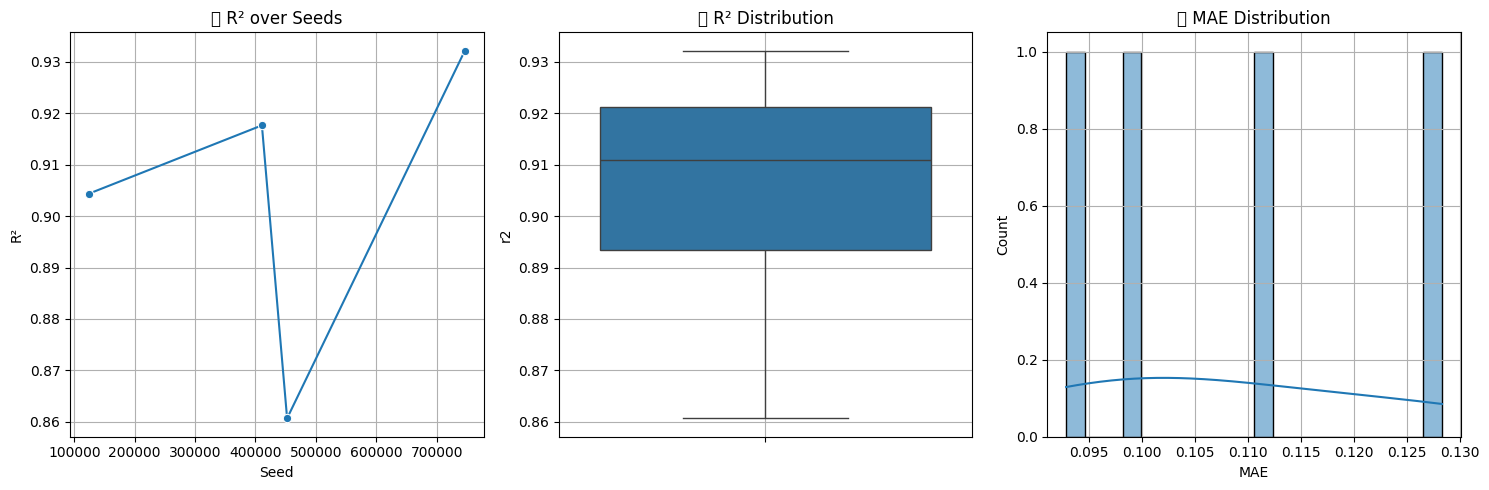

✅ Stability analysis complete:
{
    "r2_mean": 0.9037,
    "r2_std": 0.0309,
    "mae_mean": 0.1081,
    "mae_std": 0.0155,
    "mse_mean": 0.024032,
    "mse_std": 0.00756,
    "runs": 4
}
📁 Saved metrics: /mnt/d/projects/wind_pressure_prediction_GNN/final_model/gnn_0.01lr_16bs_128hc_3lyr_relu_bn_maxpool_adam/stability_gnn_0.01lr_16bs_128hc_3lyr_relu_bn_maxpool_adam.json
🖼️  Saved plot: /mnt/d/projects/wind_pressure_prediction_GNN/final_model/gnn_0.01lr_16bs_128hc_3lyr_relu_bn_maxpool_adam/stability_plot_gnn_0.01lr_16bs_128hc_3lyr_relu_bn_maxpool_adam.png


In [23]:
# 📁 src/tuning/analyze_stability_gnn.py


# === 📌 Пути (адаптируй под свой проект)

ARCH_LABEL = SAVE_ROOT.name  # используем имя папки как имя модели

# === 📥 Загрузка CSV
df = pd.read_csv(LOG_CSV_PATH)

# ➕ Добавим колонку run по индексу
df["run"] = range(1, len(df) + 1)

# === 📊 Подсчёт стабильности
stability = {
    "r2_mean":  round(df["r2"].mean(), 4),
    "r2_std":   round(df["r2"].std(), 4),
    "mae_mean": round(df["mae"].mean(), 4),
    "mae_std":  round(df["mae"].std(), 4),
    "mse_mean": round(df["mse"].mean(), 6),
    "mse_std":  round(df["mse"].std(), 6),
    "runs":     len(df)
}

# === 💾 Сохраняем метрики
stability_path = SAVE_ROOT / f"stability_{ARCH_LABEL}.json"
with open(stability_path, "w") as f:
    json.dump(stability, f, indent=4)

# === 📈 Визуализация
plt.figure(figsize=(16, 5))

# ➤ R² по прогонам
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.lineplot(x="seed", y="r2", data=df, marker="o", linewidth=1.5)
plt.title("📈 R² over Seeds")
plt.xlabel("Seed")
plt.ylabel("R²")
plt.grid(True)

# ➤ Boxplot R²
plt.subplot(1, 3, 2)
sns.boxplot(y="r2", data=df)
plt.title("🎯 R² Distribution")
plt.grid(True)

# ➤ Гистограмма MAE
plt.subplot(1, 3, 3)
sns.histplot(df["mae"], bins=20, kde=True)
plt.title("📉 MAE Distribution")
plt.xlabel("MAE")
plt.grid(True)

# 💾 Сохраняем график
fig_path = SAVE_ROOT / f"stability_plot_{ARCH_LABEL}.png"
plt.tight_layout()
plt.savefig(fig_path)
plt.show()

# ✅ Вывод
print("✅ Stability analysis complete:")
print(json.dumps(stability, indent=4))
print(f"📁 Saved metrics: {stability_path}")
print(f"🖼️  Saved plot: {fig_path}")

